<a href="https://colab.research.google.com/github/sanjay2097/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

## **STEPS** 
### 1. Data Analysis
### 2. Feature Engineering
### 3. Feature Selection
### 4. Model Building
### 5. Model Validation & Selection


In [1]:
import numpy as np
import pandas as pd
from numpy import math
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### DATA ANALYSIS

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading Data
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NYC Taxi Data.csv')

In [4]:
dataset.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
dataset.shape

(1458644, 11)

There are approx 1.46 million records in our dataset.

In [6]:
dataset.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


From preliminary analysis using describe function we can see that there are anomalous values in passenger count and trip_duration that needs to be addressed later.

In [7]:
# Checking null values
dataset.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [8]:
# Checking duplicated values
dataset.duplicated().sum()

0

*There are no Null values and duplicated values in given dataset.*

In [9]:
# Copying data to new dataframe for further analysis
df = dataset.copy()

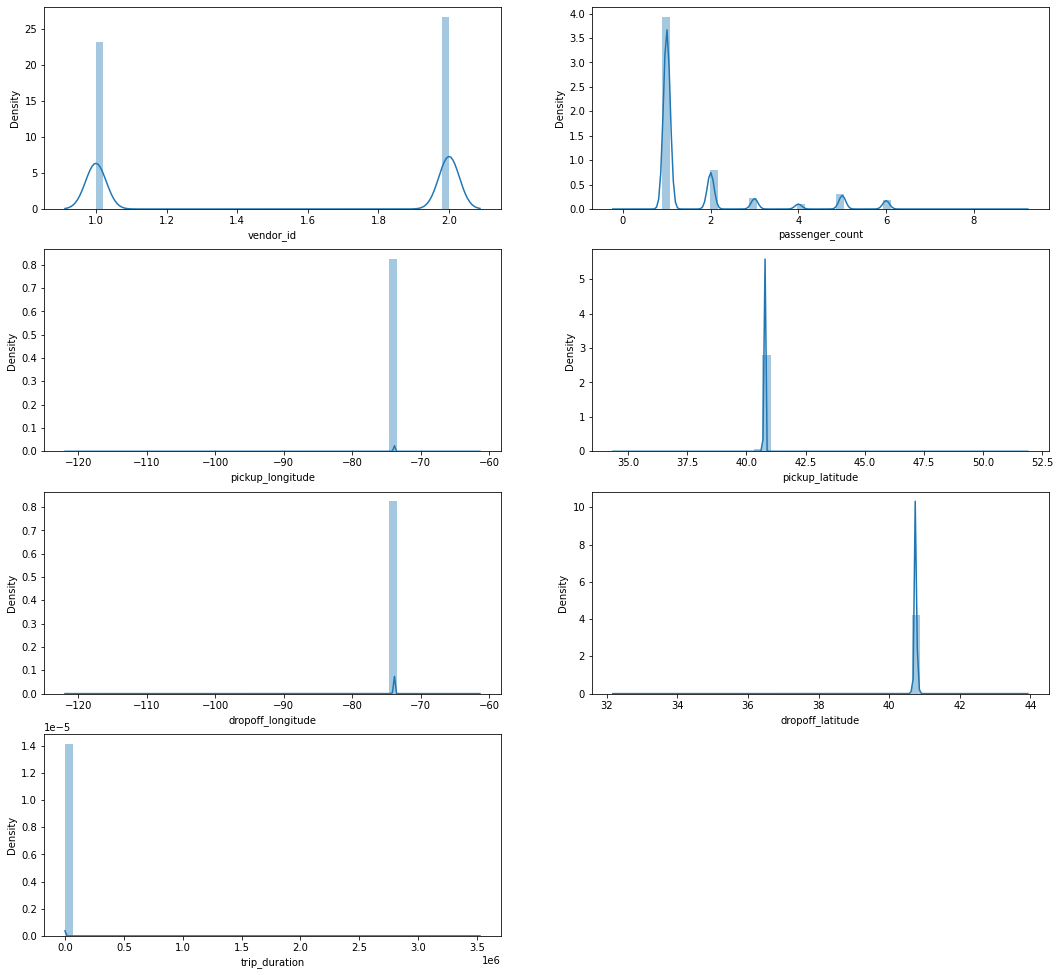

In [10]:
# Lets look at the distribution plot of the numerical features
pos = 1
fig = plt.figure(figsize=(18,26))
for i in df.describe().columns:
    ax = fig.add_subplot(6,2,pos)
    pos = pos + 1
    sns.distplot(df[i],ax=ax)

Inferences from distribution plot :

1.There are two major vendors in NYC.

2.Passenger count 1 has max distribution.

3.Distribution of trip duration is highly skewed.

### Analysis of independent variables

#### Vendor ID

Text(0.5, 0, 'Vendor ID')

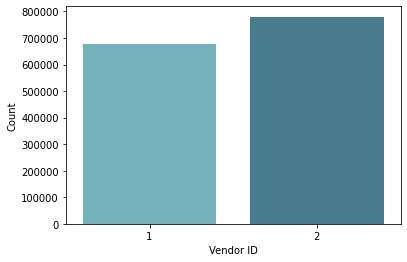

In [11]:
sns.countplot(df.vendor_id,palette='GnBu_d')
plt.ylabel('Count')
plt.xlabel('Vendor ID')

*Both the vendors seems to have almost equal market share. But Vendor 2 is evidently more famous among the population as per the above graph.*

#### Datetime

In [12]:
# Converting datetime datatype from object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [13]:
# Adding new features month , day and hour from datetime
df['hour'] = df['pickup_datetime'].dt.hour 
df['day'] = df.pickup_datetime.dt.day_name()
df['month'] = df.pickup_datetime.dt.month_name()

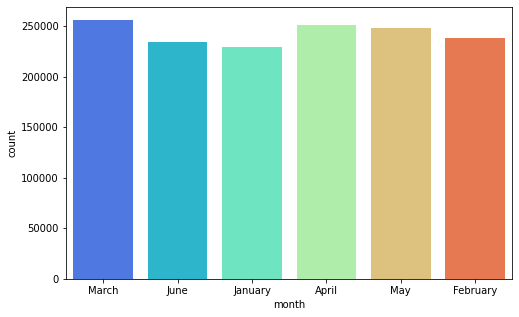

In [14]:
# Analyzing month 
data=df['month']
plt.figure(figsize=(8,5))
sns.countplot(data, palette='rainbow')
plt.show()

All the months are closely distributed with March being highest and January lowest.

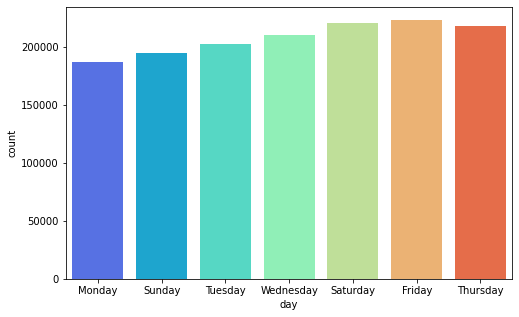

In [15]:
# Analyzing day
data=df['day']
plt.figure(figsize=(8,5))
sns.countplot(data, palette='rainbow')
plt.show()

We can see that Friday has the largest count of trips in dataset and Monday lowest.

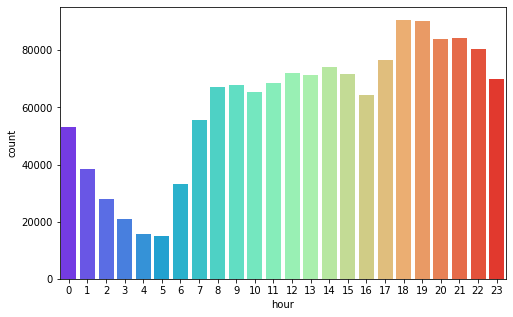

In [16]:
# Analyzing hour
data=df['hour']
plt.figure(figsize=(8,5))
sns.countplot(data, palette='rainbow')
plt.show()

We can see that max amount of trips occur between 5 to 10 pm i.e. during evening.

### Passanger Count

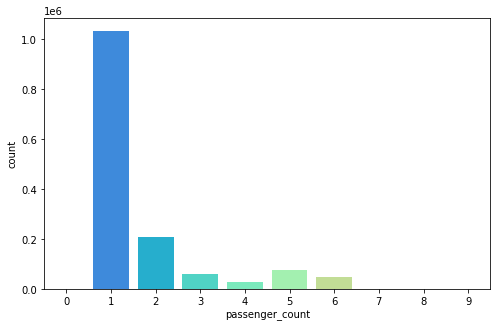

In [17]:
# Analyzing passanger count
data=df['passenger_count']
plt.figure(figsize=(8,5))
sns.countplot(data, palette='rainbow')
plt.show()

The passenger_count variable has a minimum value of 0 passengers. These observations are most likely errors and will need to be removed from the dataset.

According to the NYC Taxi & Limousine Commission, the maximum number of people allowed in a yellow taxicab, by law, is 5 passengers and one child .The observations more than 6 are likely an error and will also need to be removed from the dataset.

In [18]:
# Removing passenger count more than 6 
df = df[(df['passenger_count']>0) & (df['passenger_count']<=6)]

###store_and_fwd_flag

In [19]:
# analyzing trip data storing flag column
df['store_and_fwd_flag'].value_counts()

N    1450537
Y       8042
Name: store_and_fwd_flag, dtype: int64

Most of the trip records were not stored in vehicle memory before forwarding to the vendor because the vehicle did not have a direct connection to the server.

#### Longitude and Latitude

Looking into it, the borders of NY City coordinates comes out to be:

longitude = (-74.03, -73.77)  ,
latitude = (40.63, 40.85)


Any coordinates outside will be outliers.

In [20]:
# Max and min values of lat and long in pickup and dropoff location
print(np.min(df['pickup_longitude']), np.min(df['pickup_latitude']))
print(np.max(df['pickup_longitude']), np.max(df['pickup_latitude']))

print(np.min(df['dropoff_longitude']), np.min(df['dropoff_latitude']))
print(np.max(df['dropoff_longitude']), np.max(df['dropoff_latitude']))

-121.93334197998048 34.35969543457031
-61.33552932739258 51.88108444213867
-121.9333038330078 32.1811408996582
-61.33552932739258 43.92102813720703


In [21]:
# Removing outlier coordinates
west, south, east, north = -74.03, 40.63, -73.77, 40.85

df = df[(df.pickup_latitude> south) & (df.pickup_latitude < north)]
df = df[(df.dropoff_latitude> south) & (df.dropoff_latitude < north)]
df = df[(df.pickup_longitude> west) & (df.pickup_longitude < east)]
df = df[(df.dropoff_longitude> west) & (df.dropoff_longitude < east)]

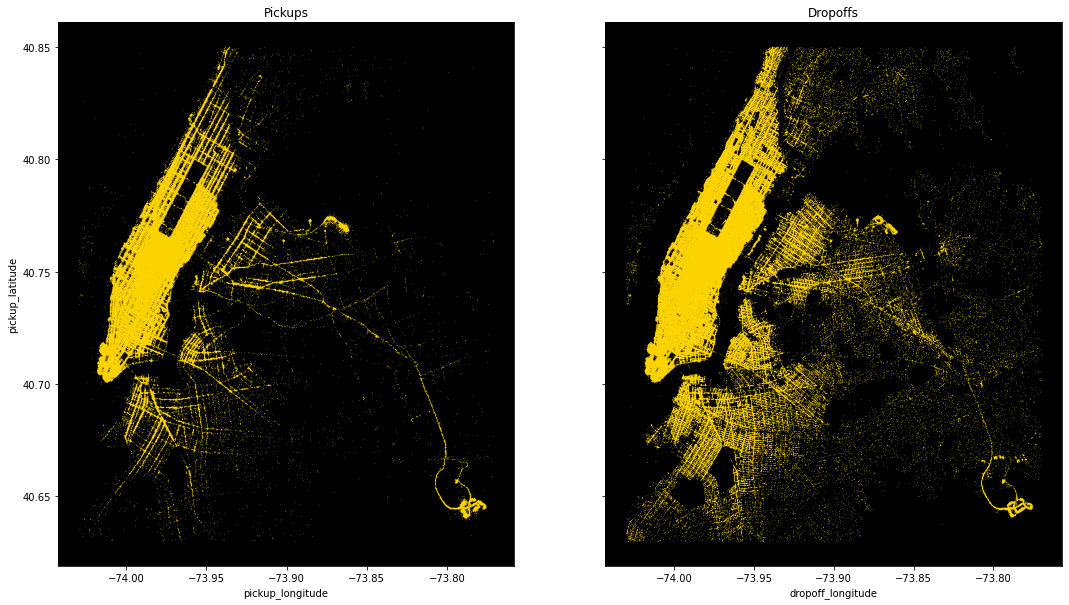

In [23]:
# Visualization of pickup and dropoff coordinates
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(18,10))

df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='gold', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='gold', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 

On comparison with NYC geographical map we can note that most of the trips are located around Manhattan and nearby places . Also we can clearly see that many trips are destined for airport located at bottom right of visualized map.

In [24]:
# Finding total diatance covered in each trip by making get_distance function
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [25]:
# Applying get_distance function to claculate each trip distance
df["distance"] = df.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)

#### Distance

In [26]:
df.distance.describe()

count    1.438573e+06
mean     3.292866e+00
std      3.662317e+00
min      0.000000e+00
25%      1.224953e+00
50%      2.068546e+00
75%      3.767414e+00
max      2.720017e+01
Name: distance, dtype: float64

We can see from describe function that there are trips where trip distance is zero which is not possible we need to drop these.

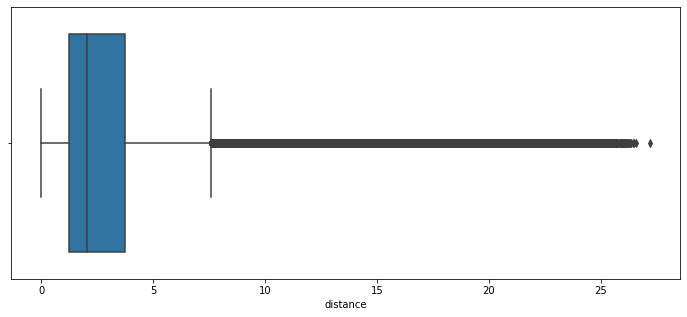

In [27]:
# Boxplot of distance
plt.figure(figsize = (12,5))
sns.boxplot(df.distance)
plt.show()

During previous analysis of longitude and latitude columns we have limited all the trips within NY city only , hence all the extreme values within distance column are actually part of our dataset and we have no further reason to remove them.

In [28]:
# Total outlier values where value is 0
len(df[df.distance==0])

5367

In [29]:
# Removing outliers 
df = df[df.distance>0]


 mu = 3.31 and sigma = 3.66



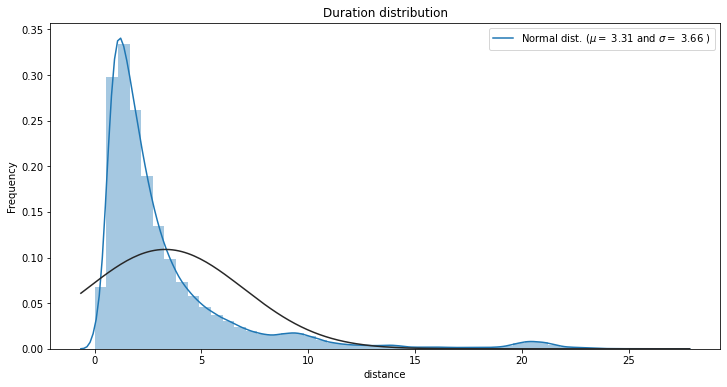

In [30]:
# Plotting distribution of trip distribution
from scipy import stats
from scipy.stats import norm, skew

plt.rcParams["figure.figsize"] = (12,6)
sns.distplot(df['distance'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['distance'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Duration distribution')
plt.show()


The distance for trips is highly right skewed i.e. most of the trips are of short distance and vey few with more than 20 km. We can normalize this using scaling.

### Bivariate Analysis

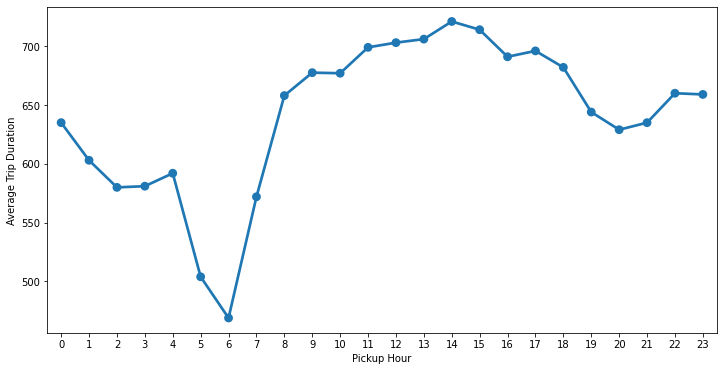

In [31]:
# Analysis between pickup hour and trip duration
group1 = df.groupby('hour').trip_duration.median()
plt.figure(figsize = (12,6))
sns.pointplot(x=group1.index, y=group1.values)
plt.ylabel('Average Trip Duration')
plt.xlabel('Pickup Hour')
plt.show()

There is sharp increase in avg trip duration from 6 am onwards till 10 am ,  most people are booking cabs at these hours to leave for work and places.The traffic remains constant 11 am onwards with slight increase during noon and it starts decreasing after 5pm.

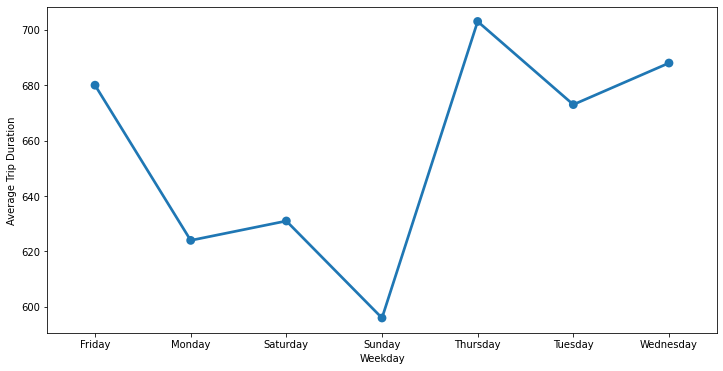

In [32]:
# Analysis between weekday and trip duration
group1 = df.groupby('day').trip_duration.median()
plt.figure(figsize = (12,6))
sns.pointplot(x=group1.index, y=group1.values)
plt.ylabel('Average Trip Duration')
plt.xlabel('Weekday')
plt.show()

The avg trip duration on sunday is slightly lower than other days , it could be because of weekend and less number of people going out.

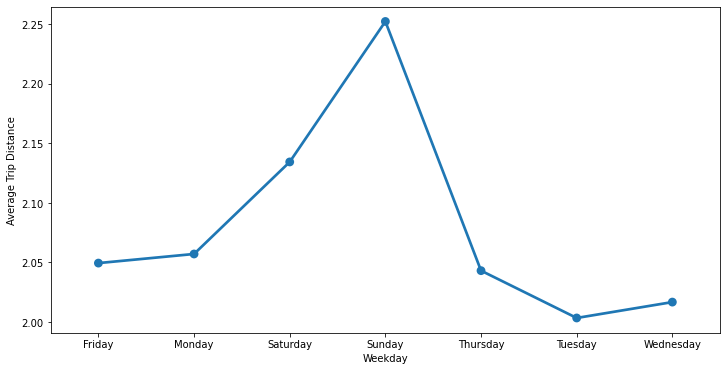

In [33]:
# Analysis between pickup hour and trip distance
group1 = df.groupby('day').distance.median()
plt.figure(figsize = (12,6))
sns.pointplot(x=group1.index, y=group1.values)
plt.ylabel('Average Trip Distance')
plt.xlabel('Weekday')
plt.show()

On sunday the trips cover more avg distance than other days , it could be because more travelling to and from airports or preople going out to meet friends and family from farther distances.

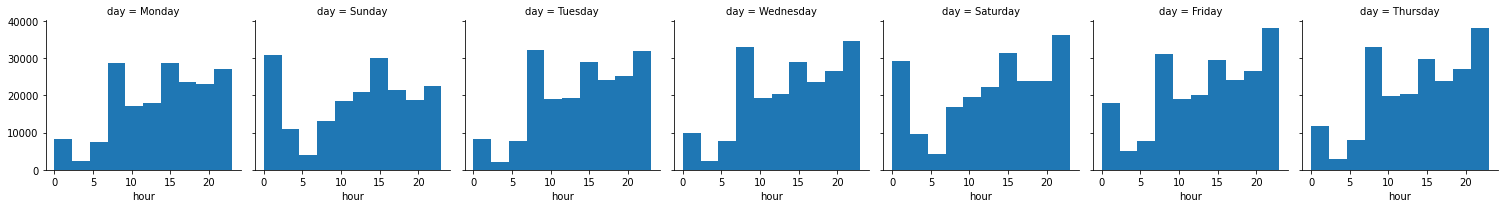

In [34]:
# Day-wise comparison of traffic
n = sns.FacetGrid(df, col='day')
n.map(plt.hist, 'hour')
plt.show()

From above we can see that weekends(Saturday and Sunday) have high late night trip distribution as compared to other days as people tend to stay out late.

#### Analyzing target variable

#### Trip Duration

In [35]:
df.trip_duration.describe()

count    1.433206e+06
mean     9.474388e+02
std      5.260065e+03
min      1.000000e+00
25%      3.950000e+02
50%      6.570000e+02
75%      1.060000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

We can clearly see that there are several outliers present in trip duartion that needs to be adressed.

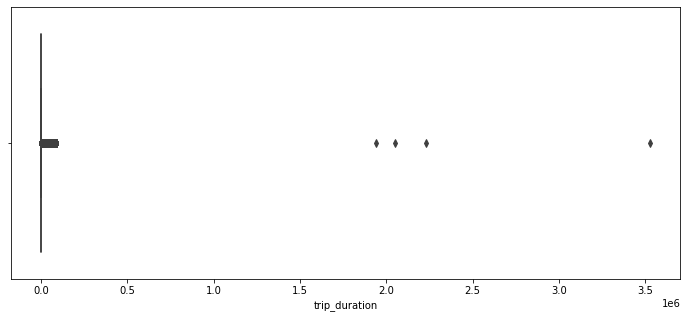

In [36]:
# boxplot trip duration
plt.figure(figsize = (12,5))
sns.boxplot(df.trip_duration)
plt.show()

In [37]:
# Total outlier values outside 3 standard deviation
len(df[df.trip_duration>df.trip_duration.quantile(0.99)])

14326

In [38]:
# Removing outliers 
df = df[df.trip_duration<df.trip_duration.quantile(0.99)]


 mu = 796.41 and sigma = 561.30



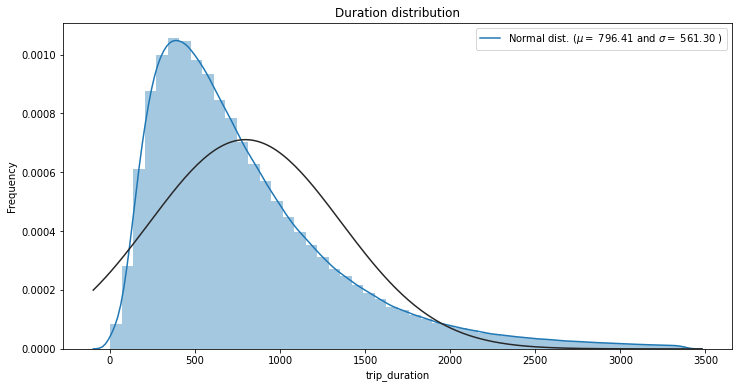

In [39]:
# Plotting trip distribution

plt.rcParams["figure.figsize"] = (12,6)
sns.distplot(df['trip_duration'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['trip_duration'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Duration distribution')
plt.show()


Trip duartion is right skewed showing that most of the trips are of shorter time duration . The longer distnaces require more time hence our inference from distance column is on the accuarate side.

### Feature Selection

In [40]:
# Copying into new dataframe
new_df=df.copy()

In [41]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1418867 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1418867 non-null  object        
 1   vendor_id           1418867 non-null  int64         
 2   pickup_datetime     1418867 non-null  datetime64[ns]
 3   dropoff_datetime    1418867 non-null  datetime64[ns]
 4   passenger_count     1418867 non-null  int64         
 5   pickup_longitude    1418867 non-null  float64       
 6   pickup_latitude     1418867 non-null  float64       
 7   dropoff_longitude   1418867 non-null  float64       
 8   dropoff_latitude    1418867 non-null  float64       
 9   store_and_fwd_flag  1418867 non-null  object        
 10  trip_duration       1418867 non-null  int64         
 11  hour                1418867 non-null  int64         
 12  day                 1418867 non-null  object        
 13  month       

In [42]:
# Removing unnecessary features which are of no use 
new_df.drop(['id','pickup_datetime','dropoff_datetime','store_and_fwd_flag'], 
                axis = 1, inplace = True)

In [43]:
# Removing duplicates
new_df.drop_duplicates(keep=False, inplace=True)

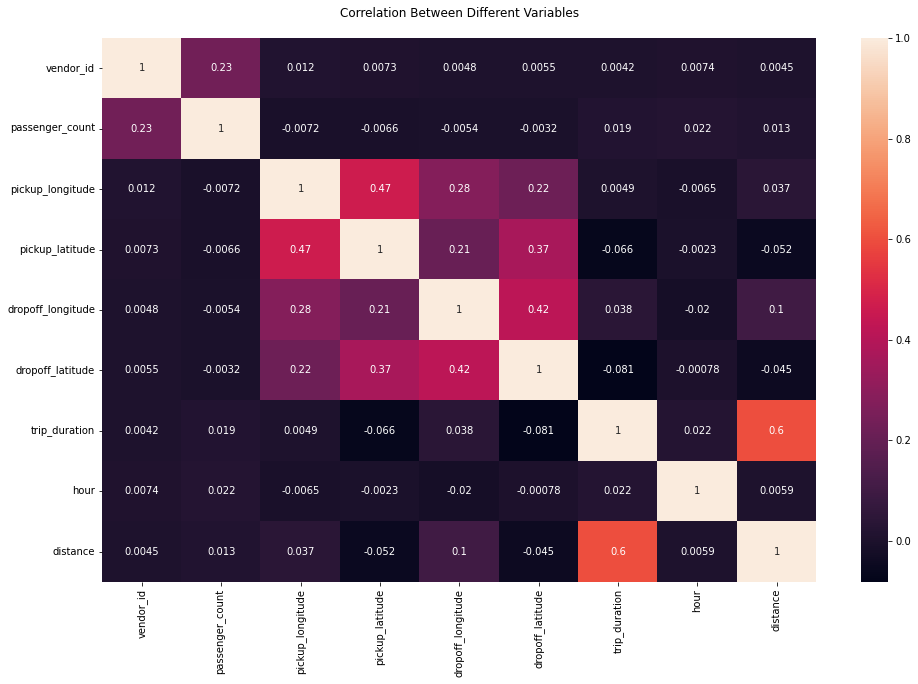

In [44]:
# Visualising the correlation between attributes
corr = new_df.corr(method='kendall')
plt.figure(figsize=(16,10))
plt.title("Correlation Between Different Variables\n")
sns.heatmap(corr, annot=True)
plt.show()

There are no high correlations in our dataset which is good.

In [45]:
# Encoding Categorical Data
df1 = pd.get_dummies(new_df, columns=['vendor_id','passenger_count','hour','month','day'], drop_first=True)

In [46]:
df1.shape

(1418859, 46)

In [47]:
# Preliminary analysis using stats OLS
import statsmodels.api as sm
x =   df1.loc[:, df1.columns != 'trip_duration']
Y = df1['trip_duration']

In [48]:
x = sm.add_constant(x)
model= sm.OLS(Y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                 5.235e+04
Date:                Fri, 18 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:20:27   Log-Likelihood:            -1.0301e+07
No. Observations:             1418859   AIC:                         2.060e+07
Df Residuals:                 1418813   BIC:                         2.060e+07
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.487e+05   1314.230   -189.250      0.000   -2.51e+05   -2.46e+05
pickup_longitude  -1721.2268      9.830   -175.093      0.000   -1740.494   -1701.960
pickup_latitude    1216.9367     12.782     95.211      0.000    1191.885    1241.988
dropoff_longitude -1456.4555     10.691   -136.236      0.000   -1477.409   -1435.502
dropoff_latitude   -874.9820     11.403    -76.730      0.000    -897.332    -852.632
distance            143.0001      0.114   1259.408      0.000     142.778     143.223
vendor_id_2          -1.9203      0.607     -3.163      0.002      -3.110      -0.730
passenger_count_2    19.4759      0.840     23.179      0.000      17.829      21.123
passenger_count_3    24.7661      1.471     16.832      0.000      21.882      27.650
passenger_count_4    33.5479      2.107     15.924      0.000      29.419      37.677
passenger_count_5     5.3886      1.335      4.038      0.000       2.773       8.004
passenger_count_6     4.5222      1.657      2.729      0.006       1.275       7.769
hour_1              -31.5444      2.341    -13.473      0.000     -36.133     -26.956
hour_2              -47.0316      2.585    -18.191      0.000     -52.099     -41.964
hour_3              -72.8553      2.865    -25.427      0.000     -78.471     -67.239
hour_4             -135.1389      3.198    -42.263      0.000    -141.406    -128.872
hour_5             -241.1257      3.251    -74.165      0.000    -247.498    -234.753
hour_6             -154.8539      2.455    -63.071      0.000    -159.666    -150.042
hour_7                9.4129      2.136      4.407      0.000       5.227      13.599
hour_8              138.4894      2.043     67.801      0.000     134.486     142.493
hour_9              169.6090      2.033     83.441      0.000     165.625     173.593
hour_10             174.5745      2.045     85.380      0.000     170.567     178.582
hour_11             192.4918      2.024     95.107      0.000     188.525     196.459
hour_12             198.4460      2.003     99.089      0.000     194.521     202.371
hour_13             192.4327      2.006     95.926      0.000     188.501     196.365
hour_14             212.3963      1.995    106.480      0.000     208.487     216.306
hour_15             221.7667      2.013    110.187      0.000     217.822     225.711
hour_16             203.9467      2.063     98.869      0.000     199.904     207.990
hour_17             202.4939      1.984    102.072      0.000     198.606     206.382
hour_18             172.1082      1.916     89.835      0.000     168.353     175.863
hour_19             100.8107      1.914     52.669      0.000      97.059     104.562
hour_20              39.1686      1.940     20.185      0.000      35.365      42.972
hour_21              25.0048      1.940     12.886      0.000      21.202

Adjusted R squared is around 62% which good for preliminary check and large dataset.

For the given F statistic all the P values are around zero hence we can proceed with all the features.

####Splitting Dataset

In [49]:
# Seperating independent and target variables
X = df1.loc[:, df1.columns != 'trip_duration']
y = df1['trip_duration']

In [50]:
# Creating test and training dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)

(1135087, 45)
(283772, 45)


In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135087 entries, 603207 to 125334
Data columns (total 45 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   pickup_longitude   1135087 non-null  float64
 1   pickup_latitude    1135087 non-null  float64
 2   dropoff_longitude  1135087 non-null  float64
 3   dropoff_latitude   1135087 non-null  float64
 4   distance           1135087 non-null  float64
 5   vendor_id_2        1135087 non-null  uint8  
 6   passenger_count_2  1135087 non-null  uint8  
 7   passenger_count_3  1135087 non-null  uint8  
 8   passenger_count_4  1135087 non-null  uint8  
 9   passenger_count_5  1135087 non-null  uint8  
 10  passenger_count_6  1135087 non-null  uint8  
 11  hour_1             1135087 non-null  uint8  
 12  hour_2             1135087 non-null  uint8  
 13  hour_3             1135087 non-null  uint8  
 14  hour_4             1135087 non-null  uint8  
 15  hour_5             1135087 n

In [52]:
X_test.shape

(283772, 45)

In [53]:
# Scaling variables from index 0 to 4
sc = StandardScaler()
X_train.iloc[:, :5] = sc.fit_transform(X_train.iloc[:, :5])
X_test.iloc[:, :5] = sc.fit_transform(X_test.iloc[:, :5])

## Applying Regression Models

### Linear Regression

In [54]:
# Applying linear regression model
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.6244058010191571

In [55]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [56]:
#Train set metrics
L_MSE  = mean_squared_error((y_train), (y_train_pred))
print("MSE :" , L_MSE)

L_RMSE = np.sqrt(L_MSE)

print("RMSE :" ,L_RMSE)

L_r2 = r2_score((y_train), (y_train_pred))
print("R2 :" ,L_r2)

L_ar2 = 1-(1-r2_score((y_train), (y_train_pred)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",L_ar2)

MSE : 118225.05400404647
RMSE : 343.8387034701685
R2 : 0.6244058010191571
Adjusted R2 :  0.6243909101571052


In [57]:
# Test set metrics
Lt_MSE  = mean_squared_error((y_test), (y_test_pred))
print("MSE :" , Lt_MSE)

Lt_RMSE = np.sqrt(Lt_MSE)
print("RMSE :" ,Lt_RMSE)

Lt_r2 = r2_score((y_test), (y_test_pred ))
print("R2 :" ,Lt_r2)

Lt_ar2 = 1-(1-r2_score((y_test), (y_test_pred )))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ", Lt_ar2)

MSE : 119221.04665171781
RMSE : 345.2840086822988
R2 : 0.623009378367501
Adjusted R2 :  0.622949586251257


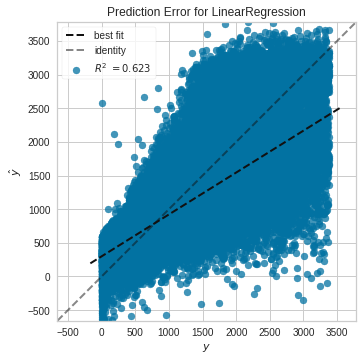

In [58]:
# Visualising predictions
from yellowbrick.regressor import PredictionError, ResidualsPlot
visualizer = PredictionError(LinearRegression())
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

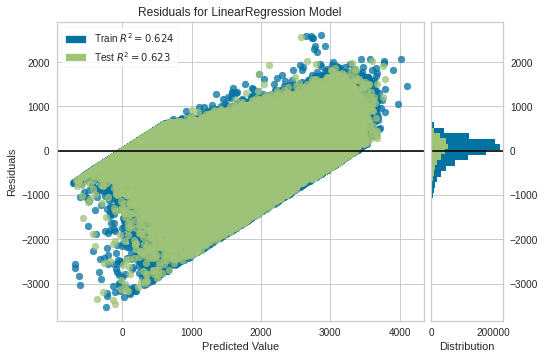

In [59]:
# Residual plot
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [60]:
# Storing the training and test set metrics for comparison
training_df = pd.DataFrame()
test_df = pd.DataFrame()

a=pd.Series(
    {'MSE':round((L_MSE),3),'RMSE':round((L_RMSE),3),'R2_score':round((L_r2),3),'Adjusted R2':round((L_ar2),3)},
    name='Linear regression ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((Lt_MSE),3),'RMSE':round((Lt_RMSE),3),'R2_score':round((Lt_r2),3),'Adjusted R2':round((Lt_ar2),3)},
     name='Linear regression ')            

test_df = test_df.append(b,ignore_index=False)

### Ridge Regression

In [61]:
# Applying ridge regression model
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='r2')

In [62]:
ridge_regressor.score(X_train, y_train)

0.6244058007915214

In [63]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)

The best fit alpha value is found out to be : {'alpha': 1}


In [64]:
y_pred_ridge_train = ridge_regressor.predict(X_train)
y_pred_ridge_test = ridge_regressor.predict(X_test)

In [65]:
# Training metrics
r_MSE  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , r_MSE)

r_RMSE = np.sqrt(r_MSE)
print("Train RMSE :" , r_RMSE)

r_r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,r_r2)

r_ar2 = 1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ", r_ar2)


Train MSE : 118225.0540756989
Train RMSE : 343.83870357436336
Train R2 : 0.6244058007915214
Train Adjusted R2 :  0.6243909099294607


In [66]:
# Testing metrics
rt_MSE  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , rt_MSE)

rt_RMSE = np.sqrt(r_MSE)
print("Test RMSE :" ,rt_RMSE)

rt_r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,rt_r2)

rt_ar2 = 1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",rt_ar2)


Test MSE : 119221.05522721402
Test RMSE : 343.83870357436336
Test R2 : 0.6230093512507986
Test Adjusted R2 :  0.6229495591302536


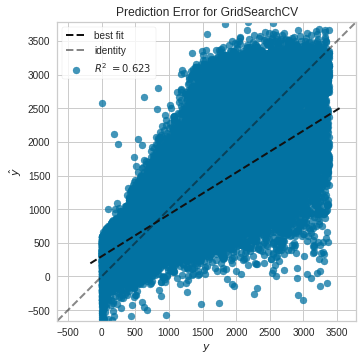

In [67]:
# Visualizing model prediction
visualizer = PredictionError(ridge_regressor)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

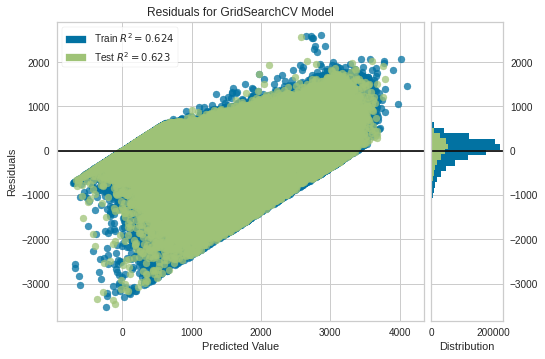

In [68]:
#Residual plot
visualizer = ResidualsPlot(ridge_regressor)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [69]:
# Storing the traing and test set metrics for comparison
a=pd.Series(
    {'MSE':round((r_MSE),3),'RMSE':round((r_RMSE),3),'R2_score':round((r_r2),3),'Adjusted R2':round((r_ar2),3)},
    name='Ridge regression ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((rt_MSE),3),'RMSE':round((rt_RMSE),3),'R2_score':round((rt_r2),3),'Adjusted R2':round((rt_ar2),3)},
     name='Ridge regression ')            

test_df = test_df.append(b,ignore_index=False)

### Lasso Regression

In [70]:
# Applying lasso regressor
lasso = Lasso()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 1, 5, 10]},
             scoring='r2')

In [71]:
lasso_regressor.score(X_train, y_train)

0.6244058010191571

In [72]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)

The best fit alpha value is found out to be : {'alpha': 1e-10}


In [73]:
y_pred_lasso_test = lasso_regressor.predict(X_test)
y_pred_lasso_train = lasso_regressor.predict(X_train)

In [74]:
# Training metrics
l_MSE  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , l_MSE)

l_RMSE = np.sqrt(l_MSE)
print("Train RMSE :" ,l_RMSE)

l_r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,l_r2)
l_ar2 = 1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",l_ar2)

Train MSE : 118225.05400404645
Train RMSE : 343.83870347016847
Train R2 : 0.6244058010191571
Train Adjusted R2 :  0.6243909101571052


In [75]:
# Test metrics
lt_MSE  = mean_squared_error(y_test, y_pred_lasso_test)
print("Test MSE :" , lt_MSE)

lt_RMSE = np.sqrt(lt_MSE)
print("Test RMSE :" ,lt_RMSE)

lt_r2 = r2_score(y_test, y_pred_lasso_test)
print("Test R2 :" ,lt_r2)

lt_ar2 = 1-(1-r2_score(y_test, y_pred_lasso_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lt_ar2)

Test MSE : 119221.04665172214
Test RMSE : 345.2840086823051
Test R2 : 0.6230093783674874
Test Adjusted R2 :  0.6229495862512433


In [76]:
# storing the traing and test set metrics for comparison
a=pd.Series(
    {'MSE':round((l_MSE),3),'RMSE':round((l_RMSE),3),'R2_score':round((l_r2),3),'Adjusted R2':round((l_ar2),3)},
    name='Lasso regression ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((lt_MSE),3),'RMSE':round((lt_RMSE),3),'R2_score':round((lt_r2),3),'Adjusted R2':round((lt_ar2),3)},
     name='Lasso regression ')            

test_df = test_df.append(b,ignore_index=False)

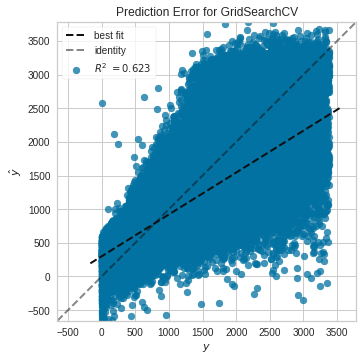

In [77]:
#Visualizing model predictions
visualizer = PredictionError(lasso_regressor)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

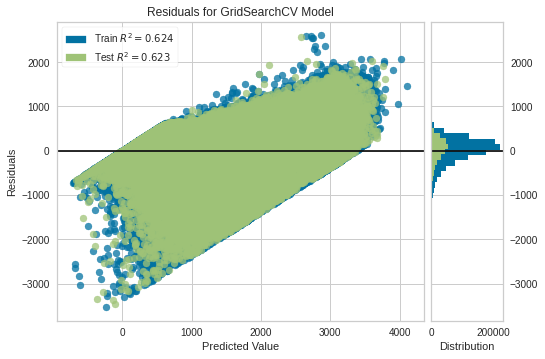

In [78]:
#Residual plot
visualizer = ResidualsPlot(lasso_regressor)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

### Decision Tree

In [90]:
from sklearn.tree import DecisionTreeRegressor

# Hyperparameter Grid
param_dt = { 'max_depth' : [9,10] , 'min_samples_split' : [40,50] , 'min_samples_leaf' : [20,30] }

dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator = dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose = 2, scoring = 'r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=40; total time=   9.2s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=40; total time=   9.3s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=40; total time=   9.2s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=40; total time=   9.2s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=40; total time=   9.2s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=50; total time=   9.3s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=50; total time=   9.3s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=50; total time=   9.3s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=50; total time=   9.4s
[CV] END max_depth=9, min_samples_leaf=20, min_samples_split=50; total time=   9.2s
[CV] END max_depth=9, min_samples_leaf=30, min_samples_split=40; total time=   9.3s
[CV] END max_dep

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [9, 10], 'min_samples_leaf': [20, 30],
                         'min_samples_split': [40, 50]},
             scoring='r2', verbose=2)

In [91]:
dt_grid.best_score_

0.6710230348314289

In [92]:
dt_grid.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=30, min_samples_split=40)

In [93]:
dt_optimal_model =dt_grid.best_estimator_

In [94]:
y_pred_dt_train = dt_optimal_model.predict(X_train)
y_pred_dt_test = dt_optimal_model.predict(X_test)

In [95]:
# Training metrics
d_MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , d_MSE)

d_RMSE = np.sqrt(d_MSE)
print("Train RMSE :" ,d_RMSE)

d_r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,d_r2)

d_ar2 = 1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",d_ar2)

Train MSE : 102637.22832014445
Train RMSE : 320.3704548177694
Train R2 : 0.6739274269631621
Train Adjusted R2 :  0.6739144994426702


In [96]:
# Test metrics
dt_MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , dt_MSE)

dt_RMSE = np.sqrt(dt_MSE)
print("Test RMSE :" ,dt_RMSE)

dt_r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,d_r2)

dt_ar2 = 1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",dt_ar2)

Test MSE : 105111.84524037663
Test RMSE : 324.2095699395325
Test R2 : 0.6739274269631621
Test Adjusted R2 :  0.6675715752306994


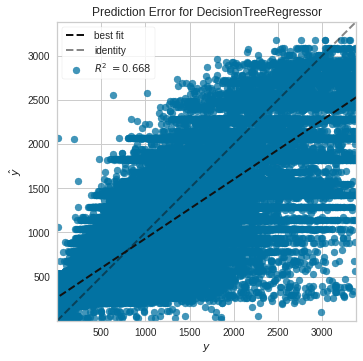

In [97]:
# Visualizing model prediction
from yellowbrick.regressor import PredictionError, ResidualsPlot
visualizer = PredictionError(dt_optimal_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

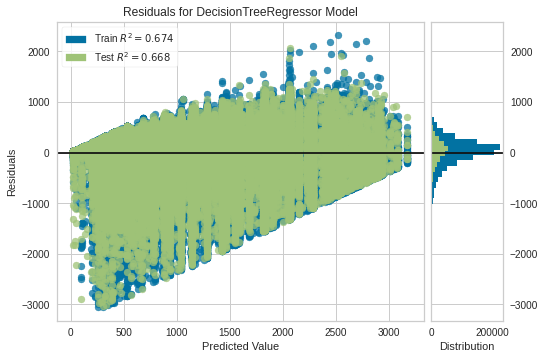

In [98]:
#Residual plot
visualizer = ResidualsPlot(dt_optimal_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [99]:
# storing the traing and test set metrics for comparison
a=pd.Series(
    {'MSE':round((d_MSE),3),'RMSE':round((d_RMSE),3),'R2_score':round((d_r2),3),'Adjusted R2':round((d_ar2),3)},
    name='Decision Tree regression ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((dt_MSE),3),'RMSE':round((dt_RMSE),3),'R2_score':round((dt_r2),3),'Adjusted R2':round((dt_ar2),3)},
     name='Decision Tree regression ')            

test_df = test_df.append(b,ignore_index=False)

In [100]:
# List of important features
importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
4,distance,0.923104
3,dropoff_latitude,0.025707
41,day_Sunday,0.009407
16,hour_6,0.006623
2,dropoff_longitude,0.005019
25,hour_15,0.003888
26,hour_16,0.003751
27,hour_17,0.003521
40,day_Saturday,0.002605
0,pickup_longitude,0.002584


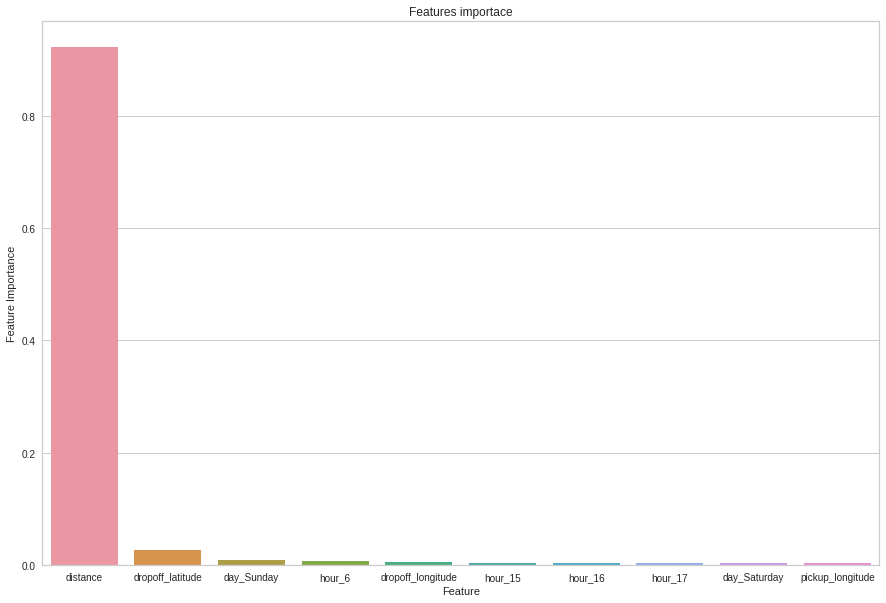

In [101]:
plt.figure(figsize=(15,10))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

#### XGB Regressor

In [79]:
# Hyperparameter Grid
param_xgb = {'n_estimators' : [100,150] ,'max_depth' : [9,10],'min_samples_split':[30,40] }

# Create an instance of the  XGBRegressor
import xgboost as xgb
xgb_m = xgb.XGBRegressor(tree_method = "gpu_hist")

# Grid search
xgb_grid = GridSearchCV(estimator = xgb_m , param_grid = param_xgb, cv = 5 , verbose=2 , scoring="r2")

xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[15:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END max_depth=9, min_samples_split=30, n_estimators=100; total time=  16.7s
[15:41:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END max_depth=9, min_samples_split=30, n_estimators=100; total time=  16.2s
[15:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END max_depth=9, min_samples_split=30, n_estimators=100; total time=  16.2s
[15:41:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END max_depth=9, min_samples_split=30, n_estimators=100; total time=  16.3s
[15:42:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of

GridSearchCV(cv=5, estimator=XGBRegressor(tree_method='gpu_hist'),
             param_grid={'max_depth': [9, 10], 'min_samples_split': [30, 40],
                         'n_estimators': [100, 150]},
             scoring='r2', verbose=2)

In [80]:
xgb_grid.best_score_

0.7930839901516742

In [81]:
xgb_grid.best_params_

{'max_depth': 10, 'min_samples_split': 40, 'n_estimators': 150}

In [82]:
xgb_model = xgb_grid.best_estimator_

In [83]:
y_pred_xgb_test = xgb_model.predict(X_test)
y_pred_xgb_train = xgb_model.predict(X_train)

In [84]:
# Training metrics
xg_MSE  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , xg_MSE)

xg_RMSE = np.sqrt(xg_MSE)
print("Train RMSE :" ,xg_RMSE)

xg_r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,xg_r2)

xg_ar2 = 1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",xg_ar2)

Train MSE : 56502.18988611107
Train RMSE : 237.70189289551539
Train R2 : 0.8204957914401881
Train Adjusted R2 :  0.8204886747903181


In [85]:
# Testing metrics
xgt_MSE  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , xgt_MSE)

xgt_RMSE = np.sqrt(xgt_MSE)
print("Test RMSE :" ,xgt_RMSE)

xgt_r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,xgt_r2)

xgt_ar2 = 1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ", xgt_ar2)

Test MSE : 65551.75554690095
Test RMSE : 256.0307707032515
Test R2 : 0.7927178315677728
Test Adjusted R2 :  0.7926849558440835


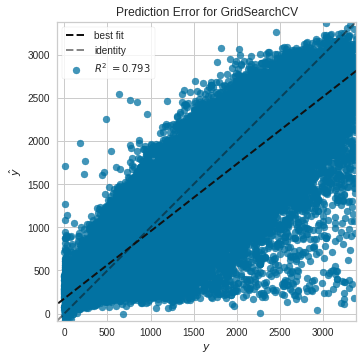

In [86]:
# Visualizing model prediction
visualizer = PredictionError(xgb_grid)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

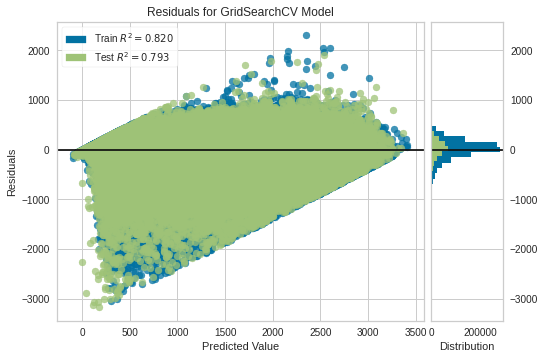

In [87]:
#Residual plot
visualizer = ResidualsPlot(xgb_grid)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [102]:
# storing the traing and test set metrics for comparison
a=pd.Series(
    {'MSE':round((xg_MSE),3),'RMSE':round((xg_RMSE),3),'R2_score':round((xg_r2),3),'Adjusted R2':round((xg_ar2),3)},
    name='XGB regressor ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((xgt_MSE),3),'RMSE':round((xgt_RMSE),3),'R2_score':round((xgt_r2),3),'Adjusted R2':round((xgt_ar2),3)},
     name='XGB regressor ')            

test_df = test_df.append(b,ignore_index=False)

In [88]:
# Checking important features
importances = xgb_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
4,distance,0.183434
15,hour_5,0.057764
14,hour_4,0.051713
11,hour_1,0.051501
16,hour_6,0.050919
12,hour_2,0.049151
13,hour_3,0.047199
24,hour_14,0.034828
25,hour_15,0.034572
26,hour_16,0.032569


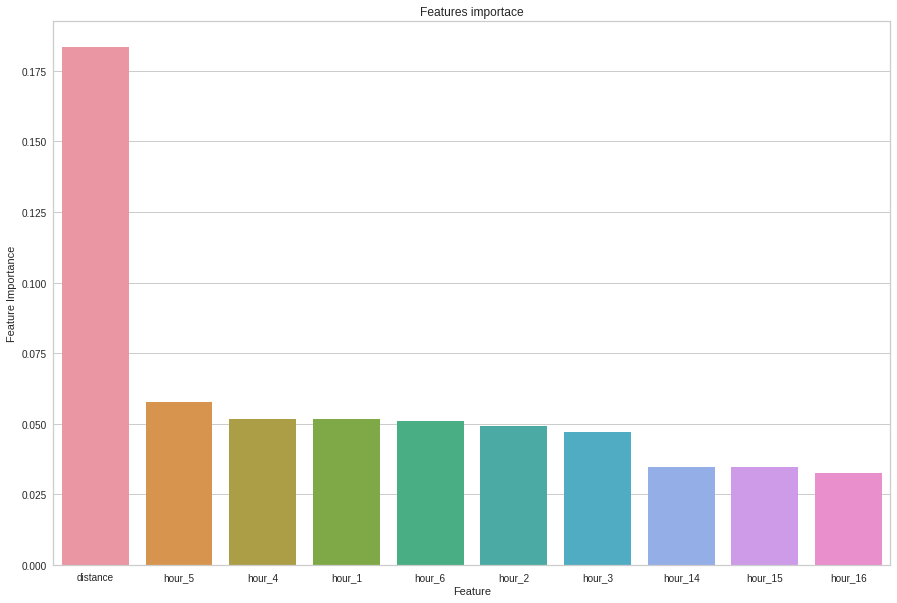

In [89]:
plt.figure(figsize=(15,10))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

#### LGBM Regressor

In [103]:
# Applying LightGBM 

params={"n_estimator":[5,10],"max_depth":[10,20] ,"min_samples_split":[20,30]}

lgb = LGBMRegressor()
gs_lgb = GridSearchCV(lgb,params,cv=5,verbose=2,scoring='r2')
gs_lgb.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..max_depth=10, min_samples_split=20, n_estimator=5; total time=  11.0s
[CV] END ..max_depth=10, min_samples_split=20, n_estimator=5; total time=  11.0s
[CV] END ..max_depth=10, min_samples_split=20, n_estimator=5; total time=  11.1s
[CV] END ..max_depth=10, min_samples_split=20, n_estimator=5; total time=  11.2s
[CV] END ..max_depth=10, min_samples_split=20, n_estimator=5; total time=  11.4s
[CV] END .max_depth=10, min_samples_split=20, n_estimator=10; total time=  11.4s
[CV] END .max_depth=10, min_samples_split=20, n_estimator=10; total time=  11.1s
[CV] END .max_depth=10, min_samples_split=20, n_estimator=10; total time=  11.0s
[CV] END .max_depth=10, min_samples_split=20, n_estimator=10; total time=  10.9s
[CV] END .max_depth=10, min_samples_split=20, n_estimator=10; total time=  11.0s
[CV] END ..max_depth=10, min_samples_split=30, n_estimator=5; total time=  11.1s
[CV] END ..max_depth=10, min_samples_split=30, n_

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'max_depth': [10, 20], 'min_samples_split': [20, 30],
                         'n_estimator': [5, 10]},
             scoring='r2', verbose=2)

In [104]:
print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

0.7614648788398489
{'max_depth': 20, 'min_samples_split': 20, 'n_estimator': 5}


In [105]:
lgb_model = gs_lgb.best_estimator_

In [106]:
y_pred_lgb_train = lgb_model.predict(X_train)
y_pred_lgb = lgb_model.predict(X_test)

In [107]:
# Training metrics
lg_MSE  = mean_squared_error(y_train, y_pred_lgb_train)
print("Train MSE :" , lg_MSE)

lg_RMSE = np.sqrt(lg_MSE)
print("Train RMSE :" ,lg_RMSE)

lg_r2 = r2_score(y_train, y_pred_lgb_train)
print("Train R2 :" ,lg_r2)

lg_ar2 = 1-(1-r2_score((y_train), (y_pred_lgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lg_ar2)

Train MSE : 74751.06856926194
Train RMSE : 273.40641647419676
Train R2 : 0.7625201531202257
Train Adjusted R2 :  0.7625107379597957


In [108]:
# Testing metrics
lgt_MSE  = mean_squared_error(y_test, y_pred_lgb)
print("Test MSE :" , lgt_MSE)

lgt_RMSE = np.sqrt(lgt_MSE)
print("Test RMSE :" ,lgt_RMSE)

lgt_r2 = r2_score(y_test, y_pred_lgb)
print("Test R2 :" ,lgt_r2)

lgt_ar2 = 1-(1-r2_score((y_test), (y_pred_lgb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lgt_ar2)

Test MSE : 75925.30534677533
Test RMSE : 275.54546874658513
Test R2 : 0.7599154774749186
Test Adjusted R2 :  0.7598773991757369


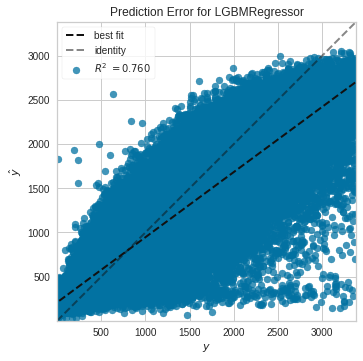

In [109]:
# Visualizing model prediction
visualizer = PredictionError(lgb_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

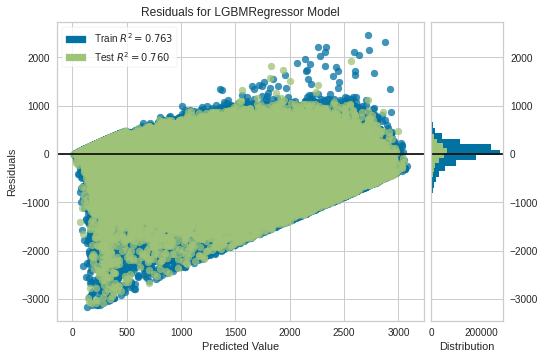

In [110]:
#Residual plot
visualizer = ResidualsPlot(lgb_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.poof()

In [111]:
# storing the traing and test set metrics for comparison
a=pd.Series(
    {'MSE':round((lg_MSE),3),'RMSE':round((lg_RMSE),3),'R2_score':round((lg_r2),3),'Adjusted R2':round((lg_ar2),3)},
    name='LGBM regression ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((lgt_MSE),3),'RMSE':round((lgt_RMSE),3),'R2_score':round((lgt_r2),3),'Adjusted R2':round((lgt_ar2),3)},
     name='LGBM regression ')            

test_df = test_df.append(b,ignore_index=False)

In [112]:
# Checking important features
importances = lgb_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
3,dropoff_latitude,395
4,distance,363
2,dropoff_longitude,321
0,pickup_longitude,288
1,pickup_latitude,262
41,day_Sunday,130
40,day_Saturday,119
25,hour_15,61
26,hour_16,60
27,hour_17,59


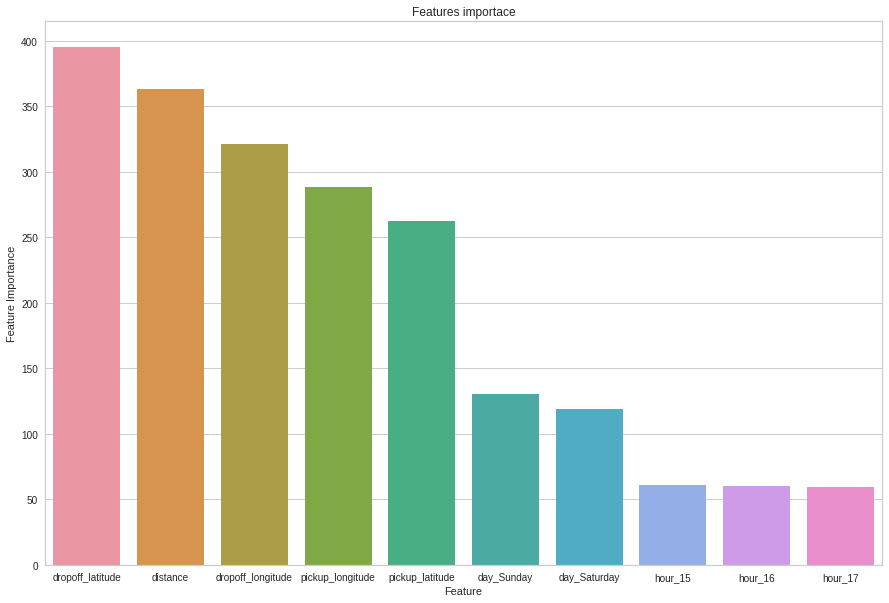

In [113]:
plt.figure(figsize=(15,10))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

###CatBoost Regressor

In [ ]:
pip install catboost

In [ ]:
import catboost as cb
params = {'iterations': [100,150],
        'learning_rate': [0.01, 0.1],
        'depth': [9,10],
        'l2_leaf_reg': [5,7]}

cbr = cb.CatBoostRegressor()
cbr_grid = GridSearchCV(cbr, params, scoring='r2',verbose=2, cv=5)
cbr_grid.fit(X_train, y_train)

In [116]:
print(cbr_grid.best_score_)
print(cbr_grid.best_params_)

0.7715361939756697
{'depth': 10, 'iterations': 150, 'l2_leaf_reg': 7, 'learning_rate': 0.1}


In [117]:
cat_model = cbr_grid.best_estimator_

In [118]:
y_pred_cb = cat_model.predict(X_test)
y_pred_cb_train = cat_model.predict(X_train)

In [119]:
# Training metrics
cb_MSE  = mean_squared_error(y_train, y_pred_cb_train)
print("Train MSE :" , cb_MSE)

cb_RMSE = np.sqrt(cb_MSE)
print("Train RMSE :" ,cb_RMSE)

cb_r2 = r2_score(y_train, y_pred_cb_train)
print("Train R2 :" ,cb_r2)

cb_ar2 = 1-(1-r2_score((y_train), (y_pred_cb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",cb_ar2)

Train MSE : 71542.69242382229
Train RMSE : 267.4746575356669
Train R2 : 0.7727129796621734
Train Adjusted R2 :  0.7727039686080219


In [120]:
# Testing metrics
cbt_MSE  = mean_squared_error(y_test, y_pred_cb)
print("Train MSE :" , cbt_MSE)

cbt_RMSE = np.sqrt(cbt_MSE)
print("Train RMSE :" ,cbt_RMSE)

cbt_r2 = r2_score(y_test, y_pred_cb)
print("Train R2 :" ,cbt_r2)

cbt_ar2 = 1-(1-r2_score((y_test), (y_pred_cb)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",cbt_ar2)

Train MSE : 72864.73235242126
Train RMSE : 269.934681640617
Train R2 : 0.76959336026573
Train Adjusted R2 :  0.7695842255306957


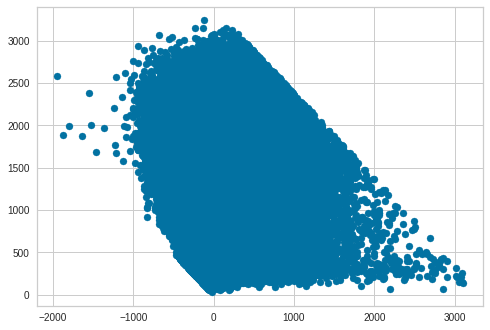

In [121]:
#Residual plot
plt.scatter((y_test)-(y_pred_cb),(y_pred_cb))

In [122]:
# storing the traing and test set metrics for comparison
a=pd.Series(
    {'MSE':round((cb_MSE),3),'RMSE':round((cb_RMSE),3),'R2_score':round((cb_r2),3),'Adjusted R2':round((cb_ar2),3)},
    name='Catboost regression ')

training_df = training_df.append(a,ignore_index=False)

b=pd.Series(
    {'MSE':round((cbt_MSE),3),'RMSE':round((cbt_RMSE),3),'R2_score':round((cbt_r2),3),'Adjusted R2':round((cbt_ar2),3)},
     name='Catboost regression ')            

test_df = test_df.append(b,ignore_index=False)

In [123]:
importances = cat_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

,Feature,Feature Importance
4,distance,36.269263
3,dropoff_latitude,11.066787
2,dropoff_longitude,8.443450
0,pickup_longitude,7.457153
1,pickup_latitude,5.215977
41,day_Sunday,3.770634
40,day_Saturday,2.769033
16,hour_6,1.616499
25,hour_15,1.501149
27,hour_17,1.403047


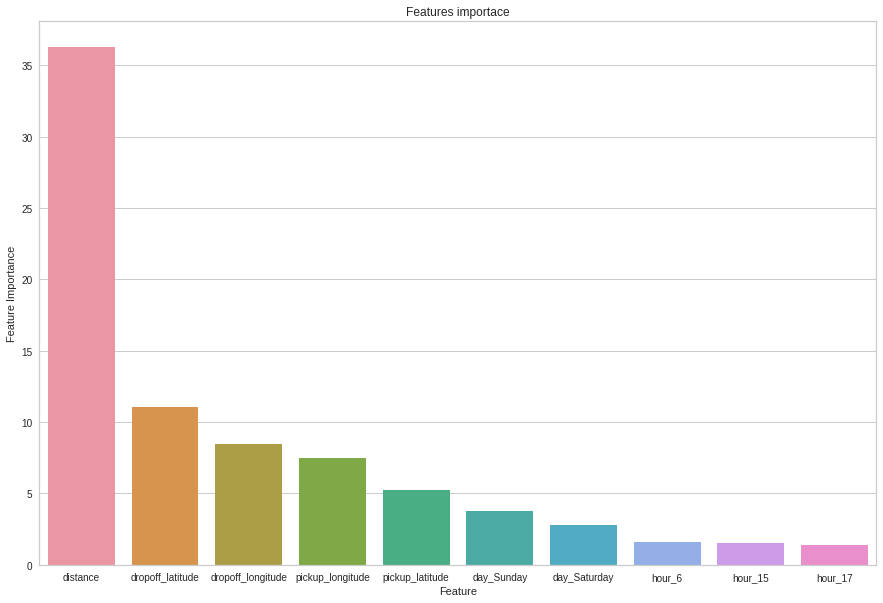

In [124]:
plt.figure(figsize=(15,10))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

### Summary

In [125]:
training_df

,MSE,RMSE,R2_score,Adjusted R2
Linear regression,118225.054,343.839,0.624,0.624
Ridge regression,118225.054,343.839,0.624,0.624
Lasso regression,118225.054,343.839,0.624,0.624
Decision Tree regression,102637.228,320.370,0.674,0.674
XGB regressor,56502.190,237.702,0.820,0.820
LGBM regression,74751.069,273.406,0.763,0.763
Catboost regression,71542.692,267.475,0.773,0.773


In [126]:
test_df

,MSE,RMSE,R2_score,Adjusted R2
Linear regression,119221.047,345.284,0.623,0.623
Ridge regression,119221.055,343.839,0.623,0.623
Lasso regression,119221.047,345.284,0.623,0.623
Decision Tree regression,105111.845,324.210,0.668,0.668
XGB regressor,65551.756,256.031,0.793,0.793
LGBM regression,75925.305,275.545,0.760,0.760
Catboost regression,72864.732,269.935,0.770,0.770


### CONCLUSION :

####**XGBoost Regressor is the best performing model with an Adjusted R2 score of around 80%.**




In this project we covered various aspects of the Machine learning development cycle. We observed that the data exploration and variable analysis is a very important aspect of the whole cycle and should be done for thorough understanding of the data. We also cleaned the data while exploring as there were some outliers which should be treated before feature engineering. Further we did feature engineering to filter and gather only the optimal features which are more significant and covered most of the variance in the dataset. Then finally we trained the models on the optimum featureset to get the results



















